In [4]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

AttributeError: 'NoneType' object has no attribute 'Rlocation'

In [2]:
!pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)


In [2]:
train_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
valid_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/valid'
test_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder/test'
data_dir = '/kaggle/input/pets-facial-expression-dataset'

dataset_name = 'Pets Facial Expression'

In [3]:
def generate_data_paths(data_dir):
    filepaths = []
    labels = []
    for folder in os.listdir(data_dir):
        if folder == 'Master Folder':
            continue
        folder_path = os.path.join(data_dir, folder)
        for file in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, file))
            labels.append(folder)
    return filepaths, labels


In [5]:
filepaths, labels = generate_data_paths(data_dir)
def create_dataframe(filepaths, labels):
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

data_df = create_dataframe(filepaths, labels)

In [6]:
def data_overview(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images and {len(df['labels'].unique())} classes.")
    for label in df['labels'].unique():
        print(f"Class '{label}' has {len(df[df['labels'] == label])} images")

In [9]:
train_df, temp_df = train_test_split(data_df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(temp_df, train_size=0.6, shuffle=True, random_state=123)

In [10]:
data_overview(train_df, "Training " + dataset_name)
data_overview(valid_df, "Validation " + dataset_name)
data_overview(test_df, "Testing " + dataset_name)


The Training Pets Facial Expression dataset has 800 images and 4 classes.
Class 'Sad' has 209 images
Class 'happy' has 192 images
Class 'Angry' has 201 images
Class 'Other' has 198 images
The Validation Pets Facial Expression dataset has 120 images and 4 classes.
Class 'Angry' has 29 images
Class 'Sad' has 28 images
Class 'Other' has 35 images
Class 'happy' has 28 images
The Testing Pets Facial Expression dataset has 80 images and 4 classes.
Class 'Other' has 17 images
Class 'Angry' has 20 images
Class 'happy' has 30 images
Class 'Sad' has 13 images


In [11]:
batch_size = 16
img_size = (224, 224)

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)

valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


In [14]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * (drop ** ((epoch + 1) // epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [20]:
history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
 1/50 ━━━━━━━━━━━━━━━━━━━━ 13:34 17s/step - accuracy: 0.1875 - loss: 2.1277

I0000 00:00:1718483907.990681     138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718483908.044883     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4399 - loss: 1.8164

W0000 00:00:1718483923.241829     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 402ms/step - accuracy: 0.4432 - loss: 1.8062 - val_accuracy: 0.6083 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7820 - loss: 0.7426 - val_accuracy: 0.7750 - val_loss: 0.6309 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8047 - loss: 0.5533 - val_accuracy: 0.7583 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.8555 - loss: 0.4384 - val_accuracy: 0.8583 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8781 - loss: 0.3271 - val_accuracy: 0.8667 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9160 - loss: 0.2348 - val_accuracy: 0.8833 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8963 - loss: 0.2765 - val_acc

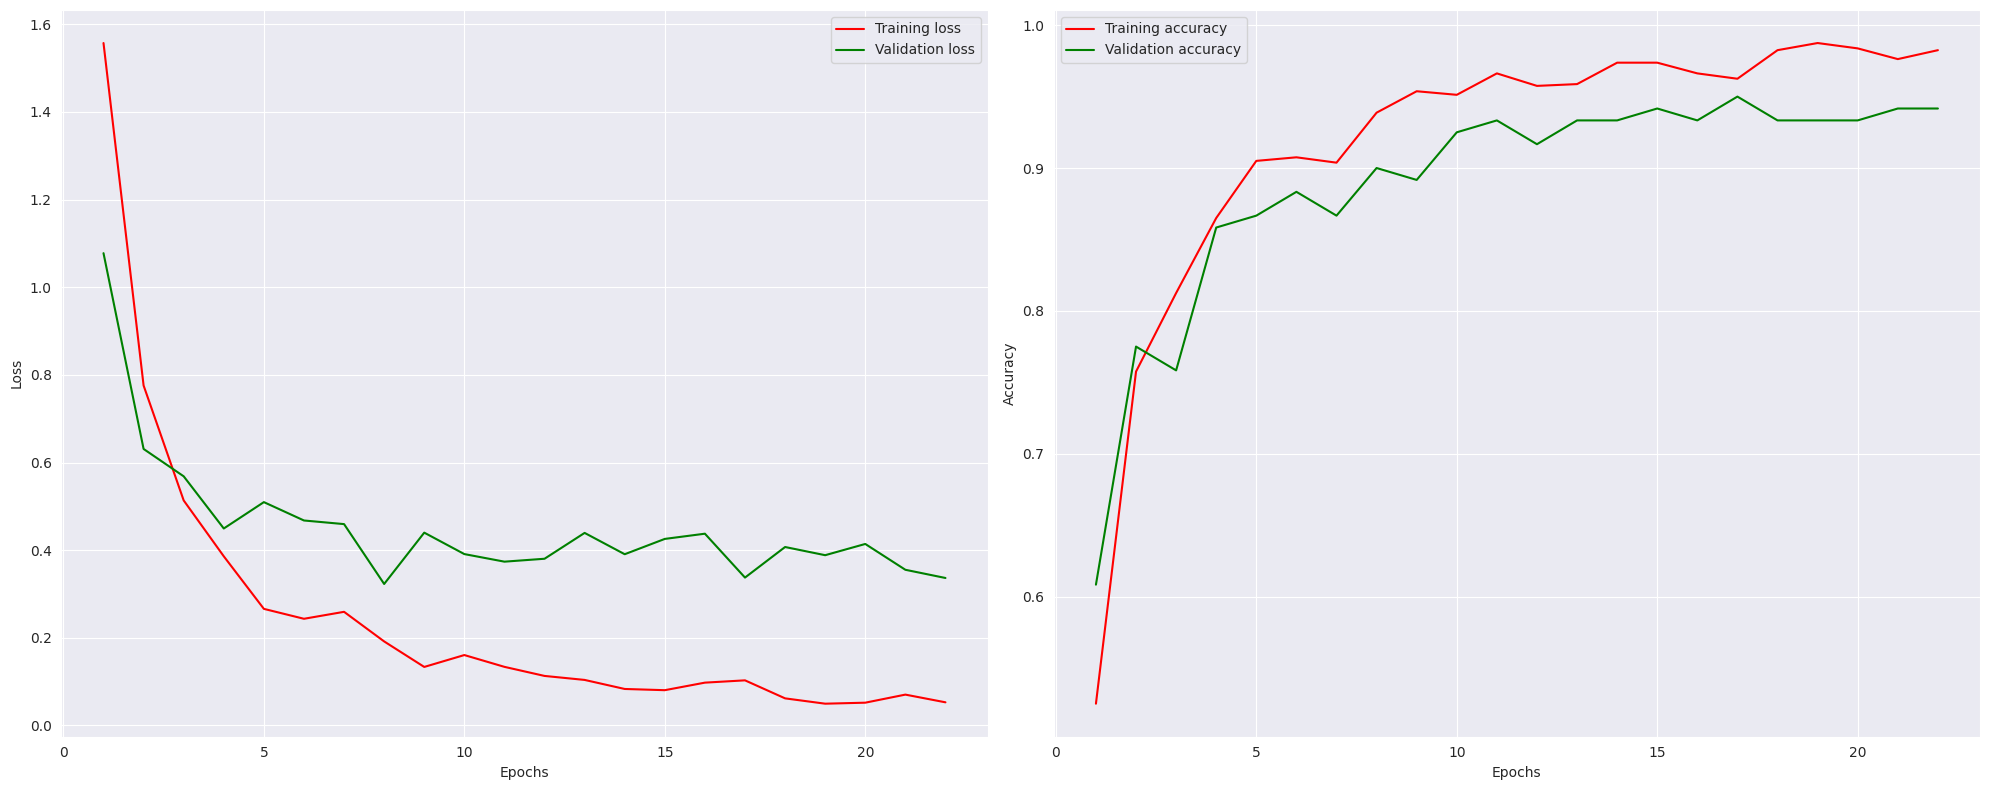

In [21]:
def plot_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

In [22]:
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(valid_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 1.0000 - loss: 0.0074
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9461 - loss: 0.3756
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0113
Train Loss: 0.006108307745307684, Train Accuracy: 1.0
Validation Loss: 0.3374278247356415, Validation Accuracy: 0.949999988079071
Test Loss: 0.01985558494925499, Test Accuracy: 1.0


In [23]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
class_labels = list(test_generator.class_indices.keys())

def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


W0000 00:00:1718484237.654985     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


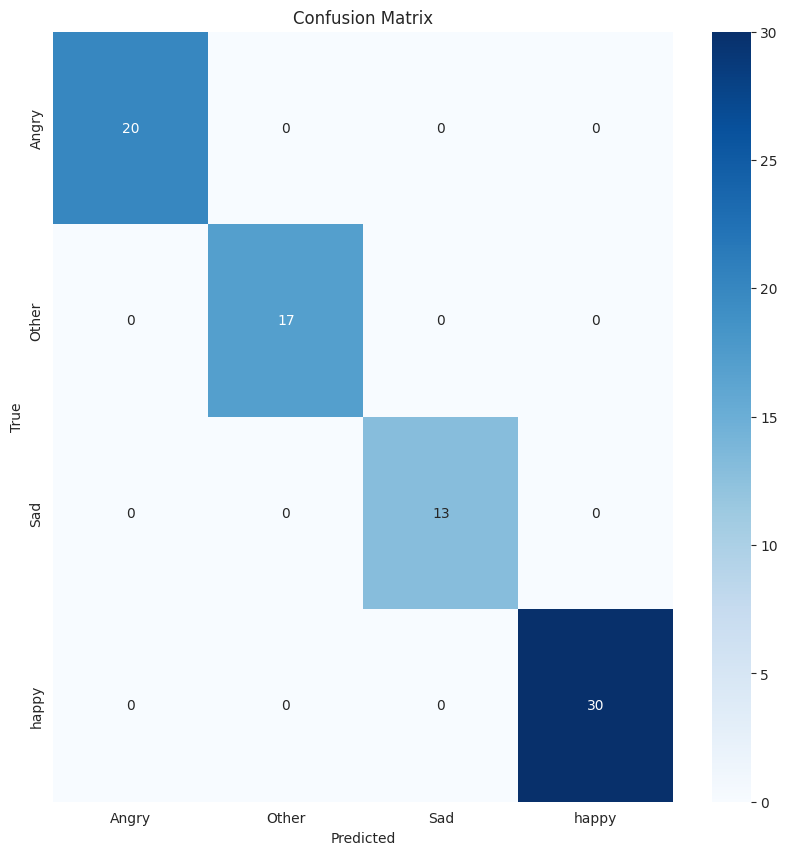

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        20
       Other       1.00      1.00      1.00        17
         Sad       1.00      1.00      1.00        13
       happy       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [24]:
plot_confusion_matrix(cm, class_labels)
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))


In [35]:
model.save_weights('animal_model.weights.h5')


In [28]:
def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"The Pet is {predicted_class_label}")
    plt.show()

In [31]:

from tensorflow.keras.preprocessing import image
model.load_weights('animal_model.weights.h5')

# Test prediction
test_images = [
    '/kaggle/input/pets-facial-expression-dataset/Angry/02.jpg',
    '/kaggle/input/pets-facial-expression-dataset/Sad/031.jpg',
    '/kaggle/input/pets-facial-expression-dataset/happy/032.jpg',
    '/kaggle/input/pets-facial-expression-dataset/Other/20.jpg'
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


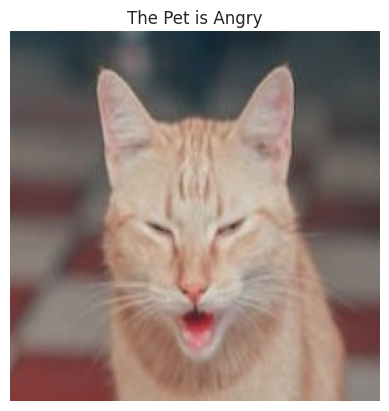

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


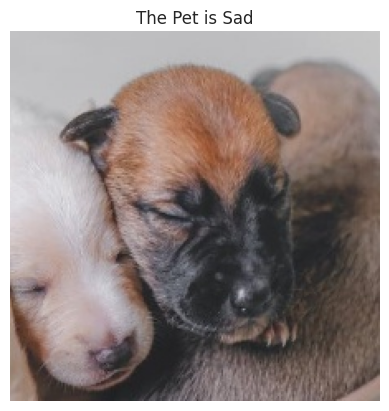

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


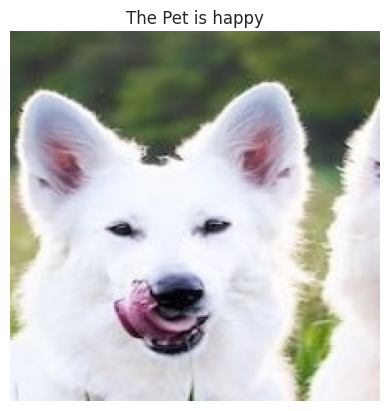

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


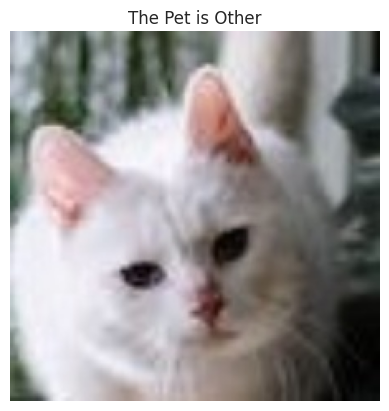

In [32]:
for img_path in test_images:
    predict_and_display(img_path, model, class_labels)